In [1]:
import pandas as pd
import catboost as catboost
from catboost import CatBoostClassifier, Pool, cv
import numpy as np
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

In [2]:
kickstarter = pd.read_csv("kickstarter_data.csv")

In [3]:
kickstarter.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country'],
      dtype='object')

In [4]:
kickstarter.category.value_counts()

Product Design     22314
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [5]:
kickstarter.head(40)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US


In [6]:
kickstarter.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

### let's just look at kickstarter campaignes that either failed or were successful, drop all the other possible states

In [7]:
kickstarter = kickstarter[(kickstarter.state=='failed')|(kickstarter.state=='successful')]

In [8]:
kickstarter.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [9]:
kickstarter.category.nunique()

159

In [10]:
kickstarter.main_category.nunique()

15

In [11]:
kickstarter.category.value_counts()

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64

In [12]:
kickstarter["state"] = kickstarter["state"].replace({"failed": 0, "successful": 1})

In [13]:
kickstarter.dropna(how="any", inplace=True)

In [14]:
kickstarter.shape

(331672, 12)

## first model including all columns but ID, name, pledged sum

In [15]:
kickstarter_first = kickstarter[
    [
        "category",
        "main_category",
        "currency",
        "deadline",
        "goal",
        "launched",
        "backers",
        "country",
        "state",
    ]
] 

In [16]:
X = kickstarter_first[kickstarter_first.columns[:-1]]

In [17]:
y = kickstarter_first[kickstarter_first.columns[-1:]]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [19]:
model = CatBoostClassifier(
    custom_loss=["Accuracy"], random_seed=42, logging_level="Silent", iterations=150
)

In [20]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes == np.object)[0]

category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
backers            int64
country           object
dtype: object


In [21]:
%%time
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)

CPU times: user 41.3 s, sys: 4.87 s, total: 46.2 s
Wall time: 8.9 s


In [22]:
model.score(X_test, y_test)  # accuracy score

0.929570670525808

In [23]:
shap_values = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
)
shap_values = shap_values[:, :-1]

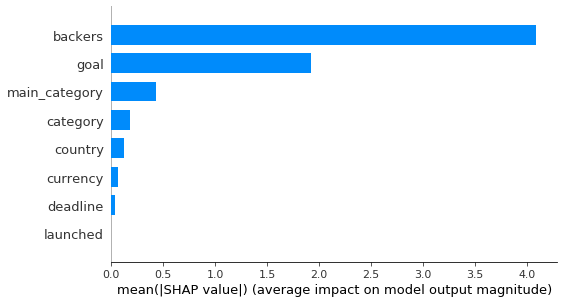

In [24]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

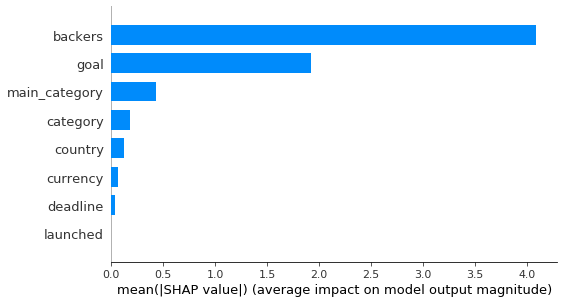

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# plt.savefig('Shap_comic_books_dow.pdf')
plt.savefig(
    "shap_first_model_summary_plot.pdf", format="pdf", dpi=1000, bbox_inches="tight"
)

## backers column is contributing the most to the prediction
## but it's a approximation to the target variable

## new dataframe without backers, but making use of all other information like duration of campaign

In [26]:
kickstarter_extended = kickstarter.copy()

In [27]:
kickstarter_extended[
    "number_special_character_name"
] = kickstarter_extended.name.str.count('[-()"#/@;:<>{}`+=~|.!?,]')
kickstarter_extended["word_count"] = kickstarter_extended["name"].str.split().map(len)

In [28]:
kickstarter_extended = kickstarter_extended.copy()
kickstarter_extended["deadline"] = pd.to_datetime(kickstarter_extended["deadline"])

In [29]:
kickstarter_extended = kickstarter_extended.copy()
kickstarter_extended["launched"] = pd.to_datetime(kickstarter_extended["launched"])

In [30]:
kickstarter_extended["delta_days"] = (
    kickstarter_extended["deadline"] - kickstarter_extended["launched"]
).dt.days
kickstarter_extended["launched_month"] = kickstarter_extended["launched"].dt.month
kickstarter_extended[
    "day_of_week_launched"
] = kickstarter_extended.launched.dt.dayofweek
kickstarter_extended["year_launched"] = kickstarter_extended.launched.dt.year
kickstarter_extended.drop(["deadline", "launched"], inplace=True, axis=1)

In [31]:
kickstarter_extended = kickstarter_extended[
    [
        "ID",
        "category",
        "main_category",
        "currency",
        "goal",
        "country",
        "number_special_character_name",
        "word_count",
        "delta_days",
        "launched_month",
        "day_of_week_launched",
        "year_launched",
        "state",
    ]
]

In [32]:
X = kickstarter_extended[kickstarter_extended.columns[:-1]]

In [33]:
y = kickstarter_extended[kickstarter_extended.columns[-1:]]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [35]:
X_train_ID = X_train.ID
X_test_ID = X_test.ID

In [36]:
X_test_ID.reset_index(inplace=True, drop=True)

In [37]:
X_train.drop(["ID"], inplace=True, axis=1)
X_test.drop(["ID"], inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# train model

In [38]:
model = CatBoostClassifier(
    custom_loss=["Accuracy"], random_seed=42, logging_level="Silent", iterations=150
)

In [39]:
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]

In [40]:
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)

In [41]:
model.score(X_test, y_test)  # accuracy score

0.7026049204052098

In [42]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)

In [43]:
def eval_crosstab(predictions, y_test=np.concatenate(y_test.values)):
    return pd.crosstab(
        index=y_test, columns=predictions, rownames=["reality"], colnames=["prediction"]
    )

In [44]:
crosstab = eval_crosstab(predictions)
crosstab

prediction,0,1
reality,,
0,15860,3966
1,5898,7444


### from the 33 000 kickstarter campaigns our model classifies more than 23 200 correctly

In [45]:
shap_values_ks = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
)
shap_values_ks = shap_values_ks[:, :-1]

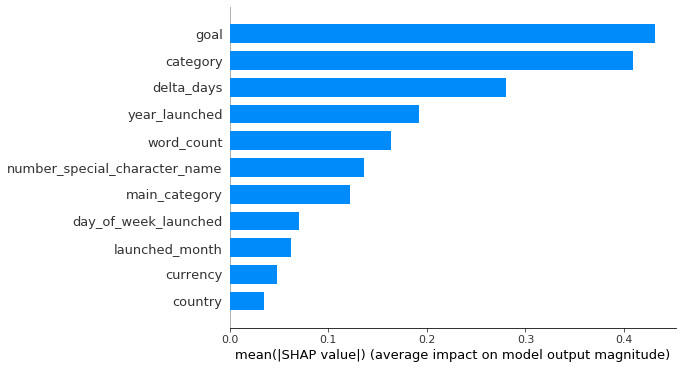

In [46]:
shap.summary_plot(shap_values_ks, X_test, plot_type="bar")

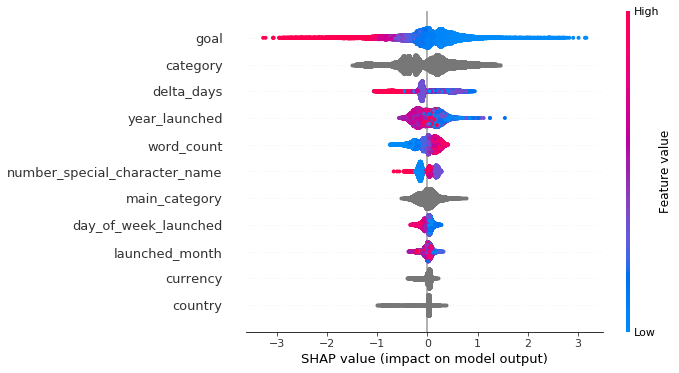

In [47]:
shap.summary_plot(shap_values_ks, X_test)

## Individual level

In [48]:
eval_df = y_test.copy()
eval_df["prediction"] = predictions
eval_df.reset_index(inplace=True, drop=True)

In [49]:
eval_df.loc[eval_df["state"] == eval_df["prediction"]].index  # rightfully predicted

Int64Index([    0,     1,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            33157, 33158, 33160, 33161, 33162, 33163, 33164, 33165, 33166,
            33167],
           dtype='int64', length=23304)

In [50]:
shap_values = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
)
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]
shap.initjs()

## Build up

In [51]:
shap.force_plot(expected_value, shap_values[10, :], X_test.iloc[10, :])

In [52]:
kickstarter[kickstarter.ID == X_test_ID[10]]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country
149718,176087010,Build Up: The Tactical Stacking Game,Tabletop Games,Games,USD,2014-11-13,4000.0,2014-10-15 15:21:20,5622.0,1,90,US


## Rah designs

In [53]:
shap.force_plot(expected_value, shap_values[33161, :], X_test.iloc[33161, :])

In [54]:
predictions_probs[33161]

array([0.75861763, 0.24138237])

In [55]:
kickstarter[kickstarter.ID == X_test_ID[33161]]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country
185861,1946128288,RAH:DESIGNS - MODERN FURNITURE DESIGN AND FABR...,Product Design,Design,USD,2015-06-28,25000.0,2015-05-29 16:48:42,327.0,0,6,US


## Analyzing categories

In [57]:
shap.force_plot(expected_value, shap_values[:1000], X_test[:1000])